In [67]:
import numpy as np
import random, math
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from functools import cmp_to_key
from time import time

# Narzędzie z poprzednich zajęć

In [33]:
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [34]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# Generowanie punktów

In [35]:
def rand_in_box(bounds_x, bounds_y, total):
    low_x, high_x = bounds_x
    low_y, high_y = bounds_y
    return [(random.uniform(low_x, high_x), random.uniform(low_y, high_y)) for _ in range(total)]

In [36]:
def rand_on_circle(origin, radius, total):
    on_circle = lambda t: (org_x + radius * math.cos(t), org_y + radius * math.sin(t))
    org_x, org_y = origin
    return [on_circle(random.uniform(0, 2*math.pi)) for _ in range(total)]

In [37]:
def rand_on_polyline(polyline, total):
    n = len(polyline)
    points_x, points_y = zip(*polyline)
    vectors = [(points_x[i+1] - points_x[i], points_y[i+1]-points_y[i])
               for i in range(n-1)]

    def norm(vec): return math.sqrt(vec[0]**2 + vec[1]**2)
    partial_sum = [0]
    for i in range(1, n):
        partial_sum.append(partial_sum[i-1] + norm(vectors[i-1]))
    total_sum = partial_sum[n-1]

    def one_rand(vectors, partial_sum, total_sum):
        t = random.uniform(0, total_sum)
        i = 0
        while i < n:
            if (partial_sum[i]) <= t <= (partial_sum[i+1]):
                break
            i += 1
        theta = ((t-partial_sum[i])/norm(vectors[i]))
        final_x = points_x[i] + (points_x[i+1] - points_x[i]) * theta
        final_y = points_y[i] + (points_y[i+1] - points_y[i]) * theta
        return (final_x, final_y)
    return [one_rand(vectors, partial_sum, total_sum) for _ in range(total)]

In [38]:
points_a = rand_in_box((-100, 100), (-100, 100), 100)
points_b = rand_on_circle(origin=(0, 0), radius=10, total=100)
points_c = [(-10, 10), (-10,-10), (10,-10), (10,10)] + rand_on_polyline(polyline=[(10,10), (10,-10), (-10,-10), (-10,10), (10, 10)], total=(100-4))
points_d = [ (0, 0), (10, 0), (10, 10), (0, 10)] + rand_on_polyline(polyline=[(0, 0), (10, 0), (10, 10), (0, 10), (0, 0)], total = 25-4) + rand_on_polyline(polyline=[(0, 0), (5, 5), (10, 0), (5, 5), (10, 10), (5, 5), (0, 10), (5,5), (0, 0)], total = 20)

# Wizualizacja zbiorów punktów

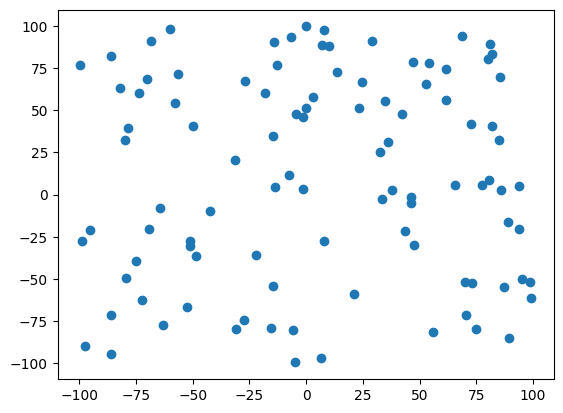

In [39]:
%matplotlib inline
plt.scatter(*zip(*points_a))
plt.show()

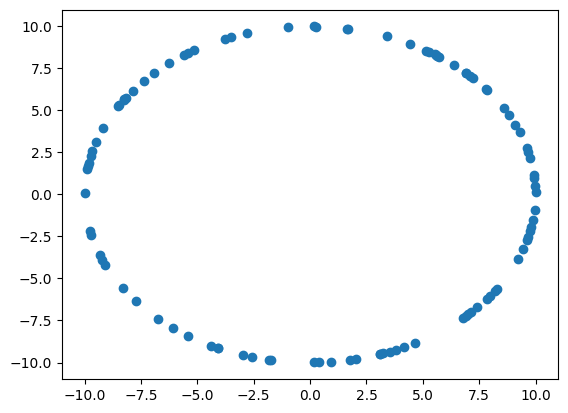

In [40]:
plt.scatter(*zip(*points_b))
plt.show()

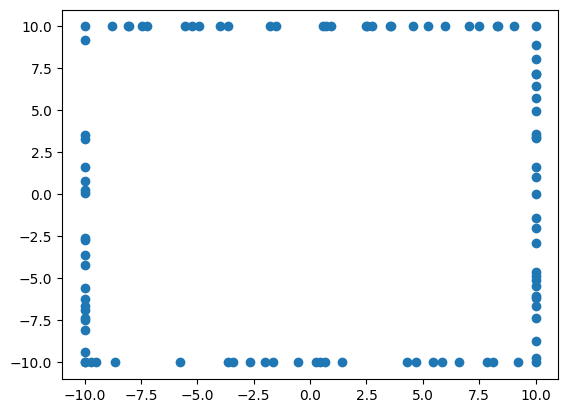

In [41]:
plt.scatter(*zip(*points_c))
plt.show()

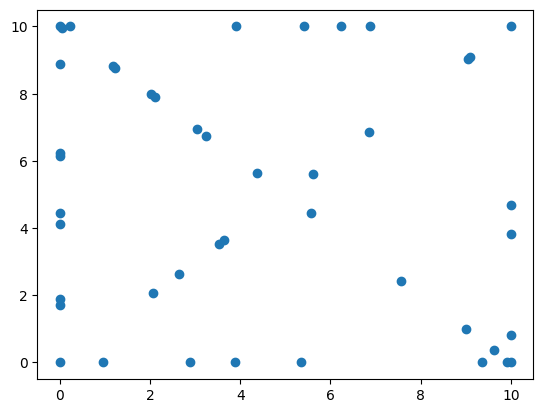

In [42]:
plt.scatter(*zip(*points_d))
plt.show()

# Implementacja algorytmu Jarvisa

In [43]:
def orientation(p, q, r, tolerance=10**(-14)):
    determinant = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1]-q[1])
    if determinant > tolerance:
        return 1
    elif determinant < -tolerance:
        return -1
    else:
        return 0

def distance(p, q):
    return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

# Zapisywanie klatek do wizualizacji
Klatki zapisywane są w globalnym zbiorze scen. W ten sposób algorytm staje się maszyną stanową i po wywołaniu dowolnego algorytmu posiada sceny do wyświetlenia. Uwaga: Jeśli komórki jupyter notebook zostaną uruchomione w innej niż przewidziana kolejność mogą wyświelić się inne niż przewidziane dane.

In [44]:
scenes = []
def dataToSceneJarvis(points, hull, current_point):
    all_points = PointsCollection(points)
    hull_points = PointsCollection(list(map(lambda i: points[i], hull)))
    hull_lines = LinesCollection([[points[hull[i-1]], points[hull[i]]] for i in range(1, len(hull))])
    current_line = LinesCollection([[points[hull[-1]], points[current_point]]])
    return Scene(points=[all_points, hull_points, PointsCollection([points[current_point]])], lines=[hull_lines, current_line])


In [45]:
def next_clockwise(points, p, hull):
    global scenes
    
    n = len(points)
    q = (p+1) % n
    for i in range(n):
        scenes.append(dataToSceneJarvis(points, hull, i))
        orient = orientation(points[p], points[i], points[q]) 
        if orient == -1 or ( orient == 0 and distance(points[p], points[i]) >= distance(points[p], points[q])):
            q = i
    return q


def get_leftmost_index(points):
    result = 0
    for i, point in enumerate(points):
        if point[0] < points[result][0]:
            result = i
    return result


def jarvis_march(points):
    global scenes
    
    leftmost = get_leftmost_index(points)
    hull = [leftmost]
    
    p = next_clockwise(points, leftmost, hull)
    while p != leftmost:
        hull.append(p)
        p = next_clockwise(points, p, hull)
    return list(map(lambda index: points[index], hull))

<IPython.core.display.Javascript object>


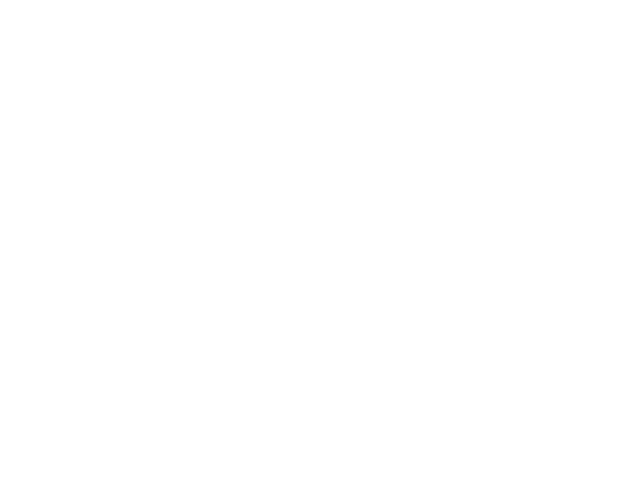

In [46]:
%matplotlib notebook
jarvis_march(points_a)
plot = Plot(scenes=scenes)
plot.draw()

# Wizualizacja wyników algorytmu Jarvisa

In [47]:
def plot_hull(hull, points, with_points = True):
    hull.append(hull[0])
    plt.plot(*zip(*hull))
    if with_points:
        plt.scatter(*zip(*points))
    plt.show()

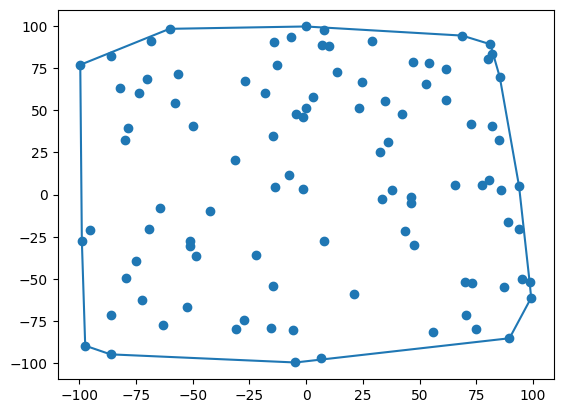

In [48]:
%matplotlib inline
plot_hull(jarvis_march(points_a), points_a)

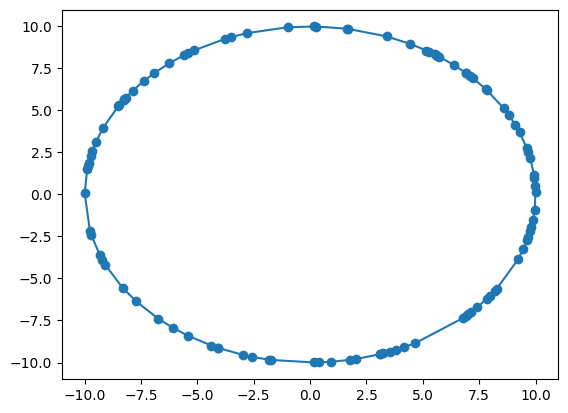

In [49]:
plot_hull(jarvis_march(points_b), points_b)

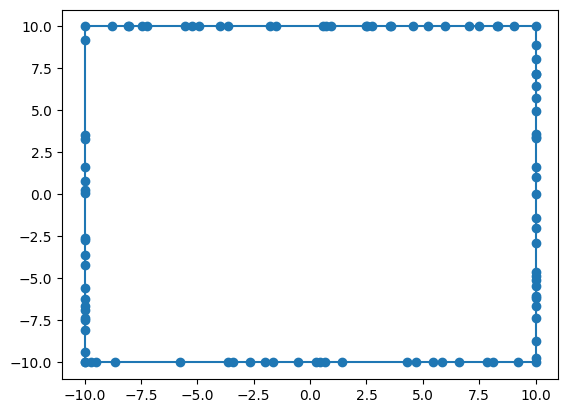

In [50]:
plot_hull(jarvis_march(points_c), points_c)

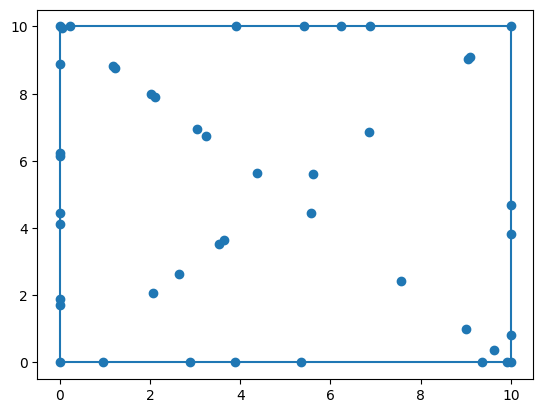

In [51]:
plot_hull(jarvis_march(points_d), points_d)

# Sortowanie punktów względem kąta

In [52]:
def dataToSceneGraham(points, hull, current_point):
    all_points = PointsCollection(points)
    hull_points = PointsCollection(hull)
    hull_lines = LinesCollection([[hull[i-1], hull[i]] for i in range(1, len(hull))])
    return Scene(points=[all_points, hull_points, PointsCollection([current_point])], lines=[hull_lines])


In [53]:
def find_bottom_index(points):
    index = 0
    for i, point in enumerate(points):
        if point[1] < points[index][1] or (point[1] == points[index][1] and point[0] < points[index][0]):
            index = i
    return index

In [54]:
def get_polar_sorted(points, anchor=None, tolerance=10**(-8)):
    if anchor is None:
        anchor = points[find_bottom_index(points)]
        
    def compare_angle(point1, point2):
        orient = orientation(anchor, point1, point2)
        if orient == 0:
            if distance(anchor, point2) <= distance(anchor, point1):
                return -1
            else:
                return 1
        else:
            if orient == -1:
                return -1
            else:
                return 1
        
    initial_sorted = sorted(points, key=cmp_to_key(compare_angle))
    result = [initial_sorted[0]]
    for i in range(1, len(initial_sorted)):
        if orientation(anchor, initial_sorted[i-1], initial_sorted[i]) == 0:
            continue
        result.append(initial_sorted[i])
    result.insert(0, anchor)
    return result

### Uwaga co do funkcji `get_polar_sorted`
Funkcja `get_polar_sorted` przy okazji sortowania usuwa punkty o tym samym kącie. 

# Wizualizowanie sortowania punktów

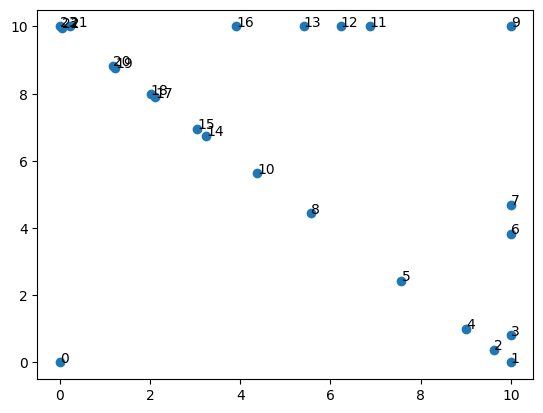

In [55]:
pts = points_d
polar_sorted = get_polar_sorted(pts)
fig, ax = plt.subplots()
x, y = zip(*polar_sorted)
ax.scatter(x, y)

for i in range(len(x)):
    ax.annotate(i, (x[i], y[i]))

<IPython.core.display.Javascript object>


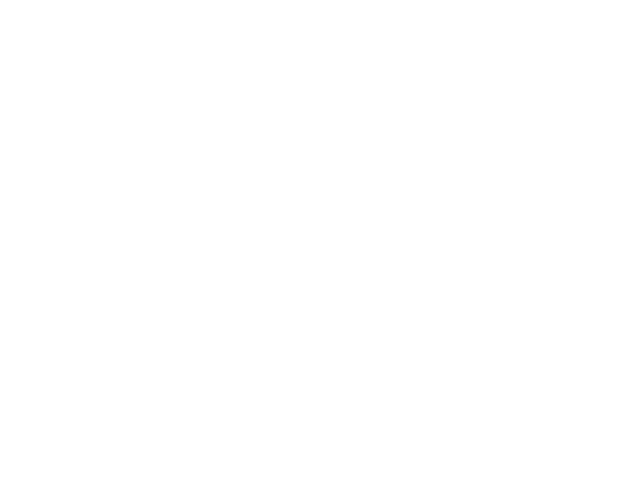

In [56]:
%matplotlib notebook
pts = points_d
polar_sorted = get_polar_sorted(pts)

scenes = [Scene([PointsCollection(polar_sorted), PointsCollection([point])]) for i, point in enumerate(polar_sorted)]
plot = Plot(scenes)
plot.draw()

In [57]:
def grahams_scan(initial_points):
    global scenes
    scenes = []
    
    points = get_polar_sorted(initial_points)
    stack = [points[0], points[1], points[2]]
    
    for i in range(3, len(points)):
        scenes.append(dataToSceneGraham(initial_points, stack, stack[-1]))
        while (len(stack) > 1 and orientation(stack[-2], stack[-1], points[i]) != -1):
            stack.pop()
        stack.append(points[i])
    return stack

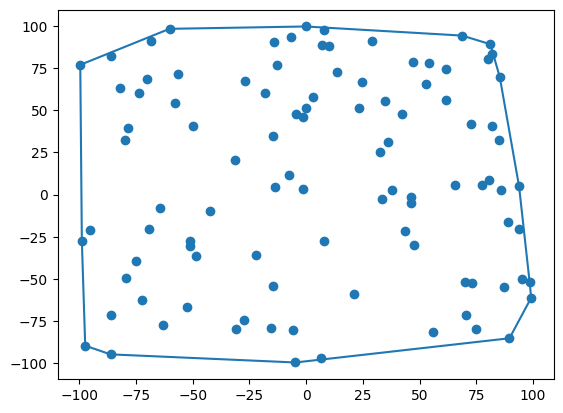

In [58]:
%matplotlib inline
plot_hull(grahams_scan(points_a), points_a)

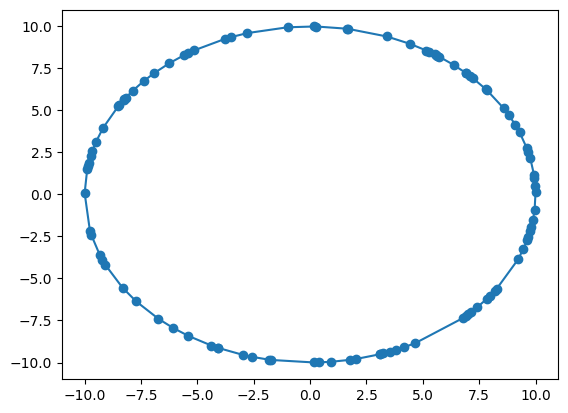

In [59]:
plot_hull(grahams_scan(points_b), points_b)

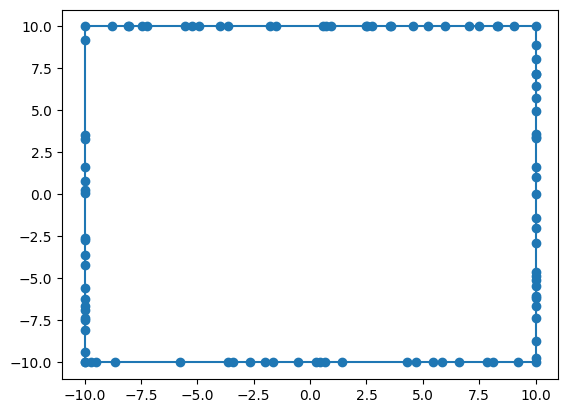

In [60]:
plot_hull(grahams_scan(points_c), points_c)

# Intraktywna wizualizacja wyjścia algorytmu Grahama

<IPython.core.display.Javascript object>


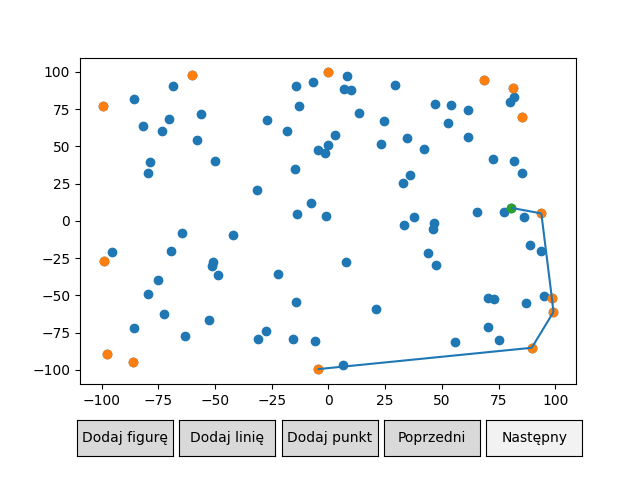

In [65]:
%matplotlib notebook
grahams_scan(points_a)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


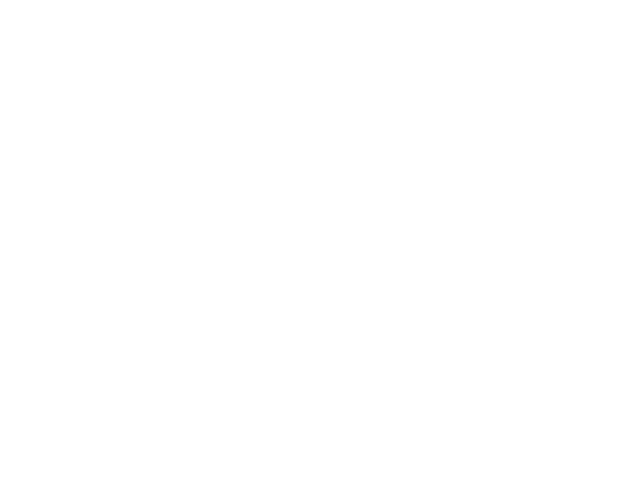

In [62]:
%matplotlib notebook
grahams_scan(points_b)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


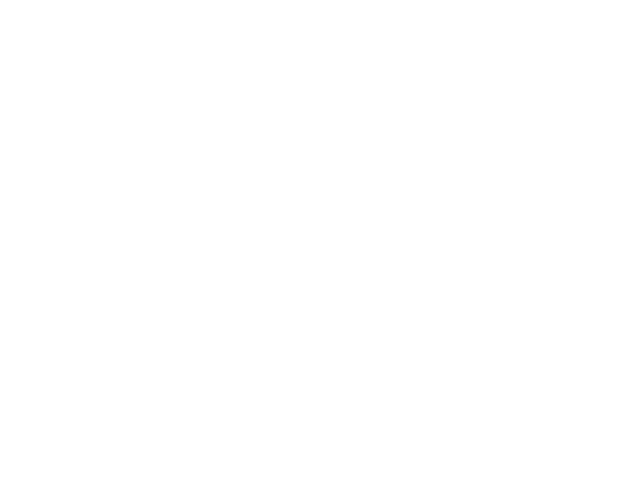

In [63]:
%matplotlib notebook
grahams_scan(points_c)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


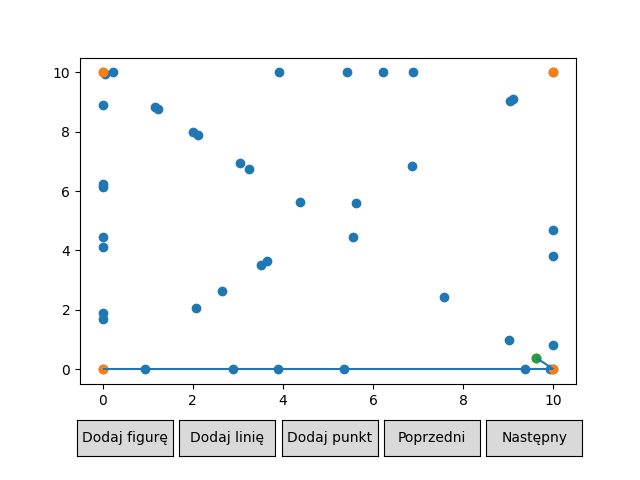

In [66]:
%matplotlib notebook
grahams_scan(points_d)
plot = Plot(scenes=scenes)
plot.draw()

# Testowanie czasu wykonania algorytmów

In [83]:
def time_execution(function, points):
    start = time()
    result = function(points)
    end = time()
    return end-start, result

In [87]:
data_names = ["points_a", "points_b", "points_c", "points_d"]
data = [points_a, points_b, points_c, points_d]
results_graham = []
results_jarvis = []

for name, points in zip(data_names, data):
    elapsed_graham, _ = time_execution(grahams_scan, points)
    results_graham.append(elapsed_graham)
    elapsed_jarvis, _ = time_execution(jarvis_march, points)
    results_jarvis.append(elapsed_jarvis)    
    print("Dataset name: {} Dataset size: {} --> Graham time: {}   Jarvis time: {}".format(name, len(points), elapsed_graham, elapsed_jarvis))


Dataset name: points_a Dataset size: 100 --> Graham time: 0.0038781166076660156   Jarvis time: 0.0215301513671875
Dataset name: points_b Dataset size: 100 --> Graham time: 0.011221885681152344   Jarvis time: 1.0017781257629395
Dataset name: points_c Dataset size: 100 --> Graham time: 0.03941917419433594   Jarvis time: 0.0030717849731445312
Dataset name: points_d Dataset size: 45 --> Graham time: 0.0007867813110351562   Jarvis time: 0.001371622085571289
